<a href="https://colab.research.google.com/github/rybinsky/TimeSeries/blob/main/StoreSales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
from datetime import datetime
import typing as tp

from IPython.display import display
from pylab import rcParams
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_pacf

#from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

from statsmodels.tsa.seasonal import seasonal_decompose, STL


rcParams["figure.figsize"] = 15, 7

sns.set(palette="Set2", font_scale=1.3)
home_dir = '/content/drive/MyDrive/StoreSales'

In [3]:
def lagplot(x, y = None, lag = 1, standardize = False, ax = None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha = 0.75,
        s = 3,
    )
    line_kws = dict(color = 'C3', )
    ax = sns.regplot(x = x_,
                     y = y_,
                     scatter_kws = scatter_kws,
                     line_kws = line_kws,
                     lowess = True,
                     ax = ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop = dict(size = "large"),
        frameon = True,
        loc = "upper left",
    )
    at.patch.set_boxstyle("square, pad = 0.0")
    ax.add_artist(at)
    ax.set(title = f"Lag {lag}", xlabel = x_.name, ylabel = y_.name)
    return ax


def plot_lags(x, y = None, lags = 6, nrows = 1, lagplot_kwargs = {}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex = True, sharey = True, squeeze = False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag = k + 1, ax = ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict = dict(fontsize = 14))
            ax.set(xlabel ="", ylabel ="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel = x.name)
    plt.setp(axs[:, 0], ylabel = y.name if y is not None else x.name)
    fig.tight_layout(w_pad = 0.1, h_pad = 0.1)
    return fig

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from warnings import filterwarnings

filterwarnings("ignore")

In [5]:
train = pd.read_csv(f'{home_dir}/train.csv', parse_dates = ['date'])
stores = pd.read_csv(f'{home_dir}/stores.csv')
oil = pd.read_csv(f'{home_dir}/oil.csv', parse_dates = ['date'])
holidays_events = pd.read_csv(f'{home_dir}/holidays_events.csv', parse_dates = ['date'])

In [6]:
test = pd.read_csv(f'{home_dir}/test.csv', parse_dates = ['date'])

In [7]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [8]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [9]:
oil

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


In [10]:
#Choose smaller df
df = train[(train['store_nbr'] == 10) & (train['family'] == 'PERSONAL CARE')]
df = df.drop(columns = ['store_nbr', 'family'])

In [11]:
df.head()

,id,date,sales,onpromotion
58,58,2013-01-01,0.0,0
1840,1840,2013-01-02,223.0,0
3622,3622,2013-01-03,169.0,0
5404,5404,2013-01-04,119.0,0
7186,7186,2013-01-05,270.0,0


In [12]:
df = df.merge(oil, on = 'date', how = 'left')

In [13]:
df.dcoilwtico.fillna(method = 'ffill', inplace = True)
df.dcoilwtico[0] = df.dcoilwtico[1] 
df

,id,date,sales,onpromotion,dcoilwtico
0,58,2013-01-01,0.0,0,93.14
1,1840,2013-01-02,223.0,0,93.14
2,3622,2013-01-03,169.0,0,92.97
3,5404,2013-01-04,119.0,0,93.12
4,7186,2013-01-05,270.0,0,93.12
...,...,...,...,...,...
1679,2992036,2017-08-11,193.0,9,48.81
1680,2993818,2017-08-12,151.0,7,48.81
1681,2995600,2017-08-13,150.0,10,48.81
1682,2997382,2017-08-14,155.0,8,47.59


In [14]:
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day_of_week'] = df['date'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6])

In [ ]:
# train = train.merge(stores, on = 'store_nbr')
# train = train.merge(oil, on = 'date', how = 'left')
# holidays_events = holidays_events.rename(columns = {'type': 'holiday_type'})
# train = train.merge(holidays_events, on = 'date', how = 'left')

# train.drop(columns = ['locale', 'locale_name', 'description', 'city', 'state', 'type'], inplace = True)

# train['dcoilwtico'].fillna(method = 'ffill', inplace = True)
# train['transferred'].fillna(False, inplace = True)
# train['onpromotion'].fillna(False, inplace = True)

# train['day'] = train['date'].dt.day
# train['month'] = train['date'].dt.month
# train['year'] = train['date'].dt.year
# train['day_of_week'] = train['date'].dt.dayofweek
# train['is_weekend'] = train['day_of_week'].isin([5, 6])

In [15]:
unique_ts = len(np.unique(train['store_nbr'])) * len(np.unique(train['family']))

print('Number of unique time series (stores * families): ' + str(unique_ts))

Number of unique time series (stores * families): 1782


In [16]:
df = df.set_index("date")
test_size = 365
df_train = df.iloc[ : -test_size]
df_test = df.iloc[-test_size : ]

In [17]:
df.drop(columns = 'id', inplace = True)

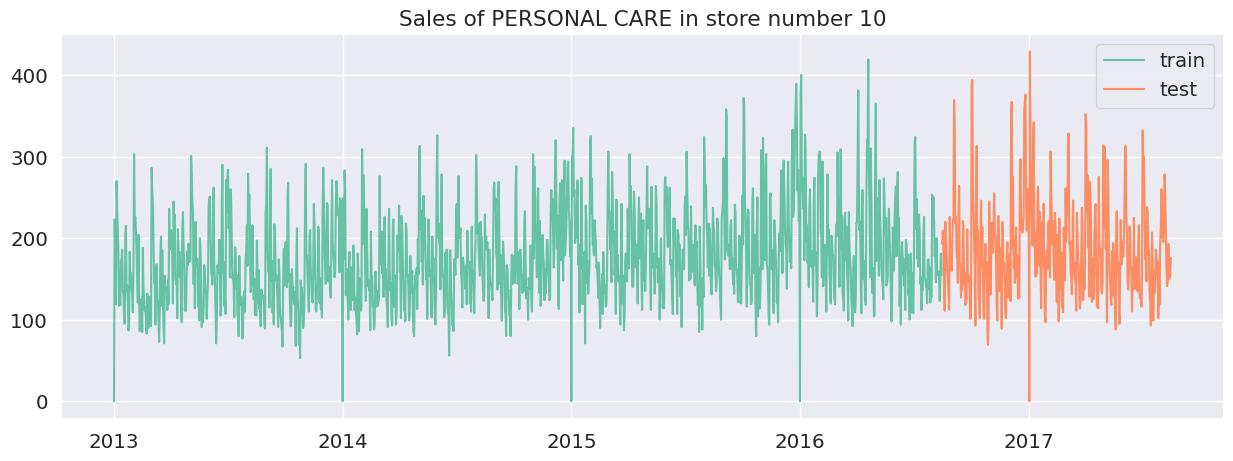

In [18]:
plt.figure(figsize = (15, 5))
plt.title("Sales of PERSONAL CARE in store number 10")
plt.plot(df_train.index, df_train['sales'].reset_index(drop = True), label="train")
plt.plot(df_test.index, df_test['sales'].reset_index(drop = True), label="test")
plt.legend();

In [ ]:
#result = STL(df['sales'], period = 365).fit()
#result.plot();

In [ ]:
# trend = df_train['sales'].rolling(
#     window = 365,
#     center = True,
#     min_periods = 183,
# ).mean()

# ax = df_train['sales'].plot(alpha = 0.5)
# ax = trend.plot(ax = ax, linewidth = 3)

In [19]:
from statsmodels.tsa.deterministic import DeterministicProcess

y_train = df_train.loc[:, 'sales'].values  # the target
y_test = df_test.loc[:, 'sales'].values

dp = DeterministicProcess(
    index = df.sales.index,  # dates from the training data
    order = 2,             # the time dummy (trend)
)

X = dp.in_sample()

X_fore = X[-test_size : ]
X = X[: -test_size]

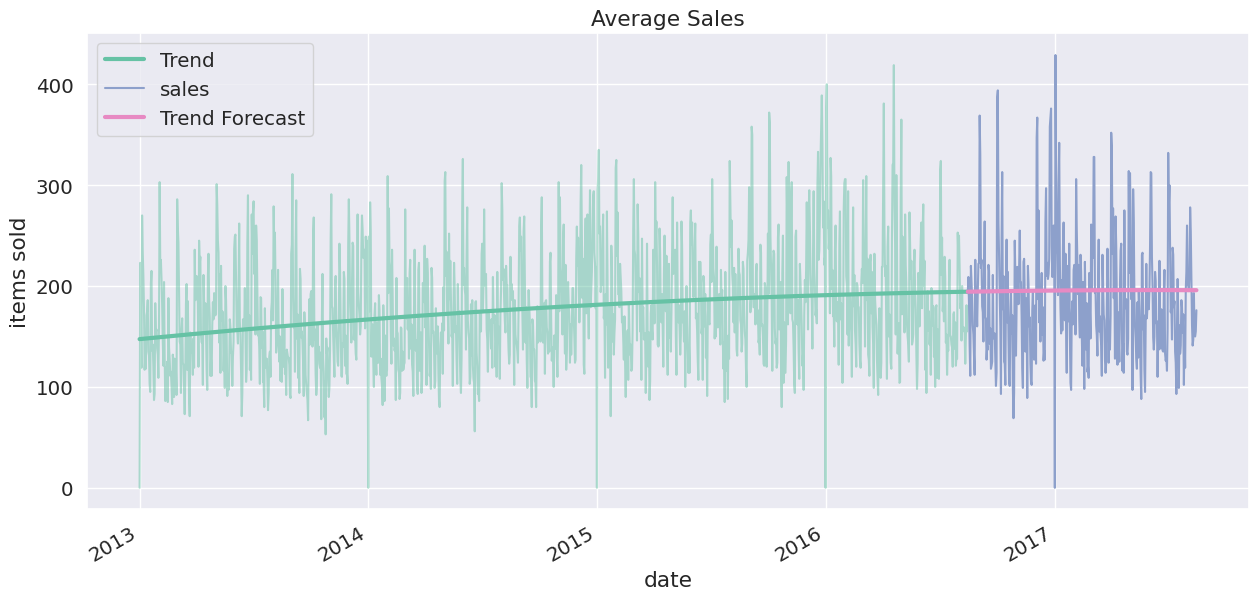

In [20]:
model = LinearRegression()
model.fit(X, y_train)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)
y_train = pd.Series(y_train, index = X.index)
y_test = pd.Series(y_test, index = df_test.index)

ax = y_train.plot(alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_test.plot(ax=ax, label="sales", color='C2')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

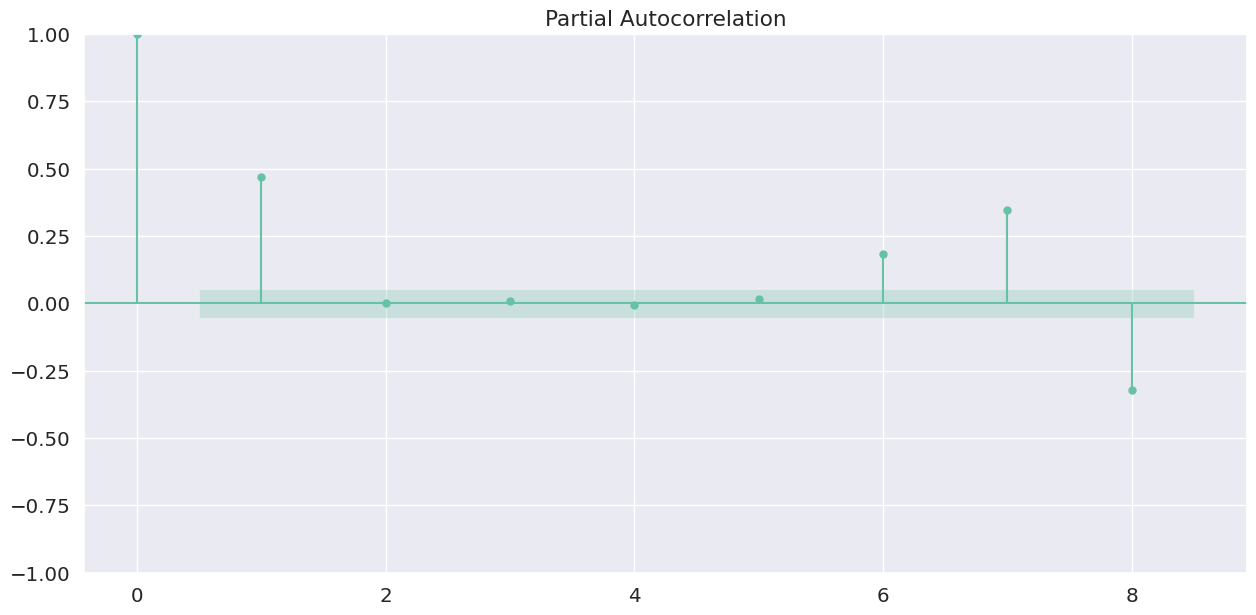

In [21]:
#y_deseason = y_train - y_pred
plot_pacf(y_train, lags = 8);
#plot_lags(y_deseason, lags = 8, nrows = 2);

In [22]:
def make_lags(ts, col, lags):
    for i in range(1, lags + 1):
        ts[f'{col}_lag_{i}'] = ts[col].shift(i)
    
    return ts
    
df = make_lags(df, col = 'sales', lags = 1)
df = df.fillna(0.0)

In [23]:
df_train = df.iloc[ : -test_size]
df_test = df.iloc[-test_size : ]

In [66]:
class BoostedResiduals:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None

    def fit(self, X_1, X_2, y):

        self.model_1.fit(X_1, y)

        y_fit = pd.DataFrame(
            self.model_1.predict(X_1),
            index = X_1.index, columns = y.columns,
        )

        y_resid = y - y_fit

        self.model_2.fit(X_2, y_resid)
        self.y_fit = y_fit
        self.y_resid = y_resid
        self.y_columns = y.columns
        

    def predict(self, X_1, X_2):

        y_pred = pd.DataFrame(
            self.model_1.predict(X_1),
            index = X_1.index, columns = self.y_columns,
        )

        y_resid = pd.DataFrame(
            self.model_2.predict(X_2),
            index = X_2.index, columns = self.y_columns,
        )
        y_pred += y_resid

        return y_pred

In [26]:
dp = DeterministicProcess(
    index = df.sales.index,  # dates from the training data
    order = 2,             # the time dummy (trend)
)

X_1 = dp.in_sample()

In [27]:
X_2 = df.drop(columns = 'sales')

In [28]:
y = df[['sales']]

In [67]:
model = BoostedResiduals(
    model_1 = LinearRegression(),
    model_2 = XGBRegressor(),
)

In [68]:
y_train, y_valid = y[:"2016-08-16"], y["2016-08-16":]
X1_train, X1_valid = X_1[: "2016-08-16"], X_1["2016-08-16" :]
X2_train, X2_valid = X_2.loc[:"2016-08-16"], X_2.loc["2016-08-16":]

In [69]:
model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

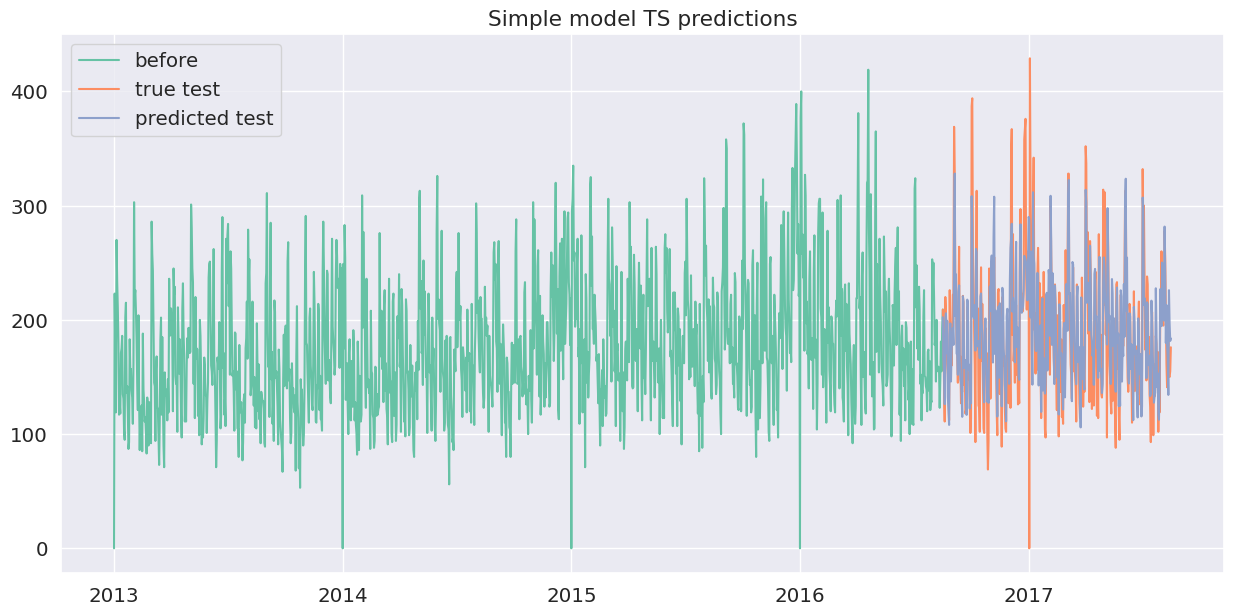

In [86]:
plt.title('Simple model TS predictions')
plt.plot(X1_train.index, y_train, label = 'before')
plt.plot(X2_valid.index, y_valid, label = 'true test')
plt.plot(X2_valid.index, y_pred, label = 'predicted test')
plt.legend();

In [82]:
print(
    "MSE:", mean_squared_error(y_true = y_valid, y_pred = y_pred),
    "MAE:", mean_absolute_error(y_true = y_valid, y_pred = y_pred),
    "R^2:", r2_score(y_true = y_valid, y_pred = y_pred),
    sep = '\n')

MSE:
1707.9475783229964
MAE:
29.578260489506565
R^2:
0.5511240640356834
